In [1]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# matplot 에서 한글을 표시하기 위한 설정
font_name = matplotlib.font_manager.FontProperties(
                fname="c:/Windows/Fonts/malgun.ttf"  # 한글 폰트 위치를 넣어주세요
            ).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["나 고양이 좋다",
             "나 강아지 좋다",
             "나 동물 좋다",
             "강아지 고양이 동물",
             "여자친구 고양이 강아지 좋다",
             "고양이 생선 우유 좋다",
             "강아지 생선 싫다 우유 좋다",
             "강아지 고양이 눈 좋다",
             "나 여자친구 좋다",
             "여자친구 나 싫다",
             "여자친구 나 영화 책 음악 좋다",
             "나 게임 만화 애니 좋다",
             "고양이 강아지 싫다",
             "강아지 고양이 좋다"]

In [4]:
# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}
word_index = [word_dict[word] for word in word_list]

# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_index) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    target = word_index[i]
    context = [word_index[i - 1], word_index[i + 1]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])

In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

In [6]:
#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)

In [7]:
#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [8]:
#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()


loss at step  10 :  4.63294
loss at step  20 :  4.1159
loss at step  30 :  3.61612
loss at step  40 :  3.6589
loss at step  50 :  3.30942
loss at step  60 :  3.24721
loss at step  70 :  3.0869
loss at step  80 :  3.17798
loss at step  90 :  3.09106
loss at step  100 :  3.02595
loss at step  110 :  2.93165
loss at step  120 :  2.79173
loss at step  130 :  2.86458
loss at step  140 :  2.79163
loss at step  150 :  2.79434
loss at step  160 :  2.7695
loss at step  170 :  2.72192
loss at step  180 :  2.69603
loss at step  190 :  2.64792
loss at step  200 :  2.68526
loss at step  210 :  2.62035
loss at step  220 :  2.66425
loss at step  230 :  2.55111
loss at step  240 :  2.61309
loss at step  250 :  2.53047
loss at step  260 :  2.53817
loss at step  270 :  2.4365
loss at step  280 :  2.44365
loss at step  290 :  2.59589
loss at step  300 :  2.48038


c:\users\chuckgu\appdata\local\programs\python\python35\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['NanumGothicOTF'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


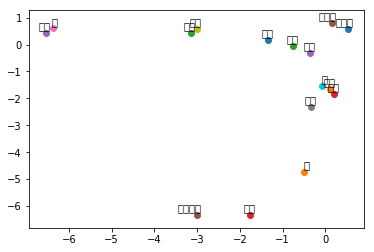

In [9]:
#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()